In [4]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown('# <span style="color:red">'+string+'</span>'))
        
if('sc' in locals() or 'sc' in globals()):
    printmd("Error: This is Watson Studio Apache.")
else:
    printmd("All is good")

# <span style="color:red">All is good</span>

In [5]:
!pip install pyspark==2.4.5

     |████████████████████████████████| 217.8MB 175kB/s  eta 0:00:01    |███████████▋                    | 79.0MB 41.5MB/s eta 0:00:04     |████████████████████████        | 163.2MB 44.9MB/s eta 0:00:02
     |████████████████████████████████| 204kB 41.6MB/s eta 0:00:01
  Stored in directory: /home/dsxuser/.cache/pip/wheels/bf/db/04/61d66a5939364e756eb1c1be4ec5bdce6e04047fc7929a3c3c
Successfully built pyspark


In [6]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

In [8]:
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

spark = SparkSession \
    .builder \
    .getOrCreate()

In [9]:
!wget https://github.com/IBM/coursera/blob/master/coursera_ds/washing.parquet?raw=true
!mv washing.parquet?raw=true washing.parquet

--2020-12-20 07:54:58--  https://github.com/IBM/coursera/blob/master/coursera_ds/washing.parquet?raw=true
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/IBM/skillsnetwork/blob/master/coursera_ds/washing.parquet?raw=true [following]
--2020-12-20 07:54:59--  https://github.com/IBM/skillsnetwork/blob/master/coursera_ds/washing.parquet?raw=true
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/IBM/skillsnetwork/raw/master/coursera_ds/washing.parquet [following]
--2020-12-20 07:54:59--  https://github.com/IBM/skillsnetwork/raw/master/coursera_ds/washing.parquet
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IBM/skillsnetwork/master/coursera_ds/washing.parquet [fo

In [12]:
dataframe = spark.read.parquet("washing.parquet")
dataframe.createOrReplaceTempView("washing")
dataframe.show()

+--------------------+--------------------+-----+--------+----------+---------+--------+-----+-----------+-------------+-------+
|                 _id|                _rev|count|flowrate|fluidlevel|frequency|hardness|speed|temperature|           ts|voltage|
+--------------------+--------------------+-----+--------+----------+---------+--------+-----+-----------+-------------+-------+
|0d86485d0f88d1f9d...|1-57940679fb8a713...|    4|      11|acceptable|     null|      77| null|        100|1547808723923|   null|
|0d86485d0f88d1f9d...|1-15ff3a0b304d789...|    2|    null|      null|     null|    null| 1046|       null|1547808729917|   null|
|0d86485d0f88d1f9d...|1-97c2742b68c7b07...|    4|    null|      null|       71|    null| null|       null|1547808731918|    236|
|0d86485d0f88d1f9d...|1-eefb903dbe45746...|   19|      11|acceptable|     null|      75| null|         86|1547808738999|   null|
|0d86485d0f88d1f9d...|1-5f68b4c72813c25...|    7|    null|      null|       75|    null| null|   

In [24]:
result = spark.sql("""
SELECT * from (
    SELECT  min(temperature) over w  AS min_temperature
            ,max(temperature) over w AS max_temperature
            ,min(voltage) over w     AS min_voltage
            ,max(voltage) over w     AS max_voltage
            ,min(flowrate) over w    AS min_flowrate
            ,max(flowrate) over w    AS max_flowrate
            ,min(frequency) over w   AS min_frequency
            ,max(frequency) over w   AS max_frequency
            ,min(hardness) over w    AS min_hardness
            ,max(hardness) over w    AS max_hardness
            ,min(speed) over w       AS min_speed
            ,max(speed) over w       AS max_speed
     FROM washing
     Window w AS (ORDER BY ts ROWS BETWEEN CURRENT ROW AND 10 FOLLOWING)
)
WHERE min_temperature IS NOT NULL
AND   max_temperature IS NOT NULL
AND   min_voltage     IS NOT NULL
AND   max_voltage     IS NOT NULL
AND   min_flowrate    IS NOT NULL
AND   max_flowrate    IS NOT NULL
AND   min_frequency   IS NOT NULL
AND   max_frequency   IS NOT NULL
AND   min_hardness    IS NOT NULL
AND   max_hardness    IS NOT NULL
AND   min_speed       IS NOT NULL
AND   max_speed       IS NOT NULL

""")

In [25]:
dataframe.count() - result.count()

7

In [26]:
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [27]:
assembler = VectorAssembler(inputCols = result.columns, outputCol = "features")

In [28]:
features = assembler.transform(result)

In [29]:
features.rdd.map(lambda r : r.features).take(10)

[DenseVector([81.0, 100.0, 221.0, 223.0, 11.0, 11.0, 68.0, 76.0, 71.0, 78.0, 1033.0, 1033.0]),
 DenseVector([81.0, 100.0, 221.0, 223.0, 11.0, 11.0, 68.0, 76.0, 72.0, 78.0, 1033.0, 1033.0]),
 DenseVector([81.0, 100.0, 221.0, 223.0, 11.0, 11.0, 68.0, 76.0, 72.0, 80.0, 1033.0, 1033.0]),
 DenseVector([81.0, 100.0, 222.0, 223.0, 11.0, 11.0, 68.0, 74.0, 72.0, 80.0, 1033.0, 1046.0]),
 DenseVector([81.0, 100.0, 222.0, 223.0, 11.0, 11.0, 68.0, 74.0, 73.0, 80.0, 1033.0, 1046.0]),
 DenseVector([80.0, 94.0, 222.0, 223.0, 11.0, 11.0, 68.0, 74.0, 73.0, 80.0, 1033.0, 1046.0]),
 DenseVector([80.0, 94.0, 222.0, 236.0, 11.0, 11.0, 68.0, 74.0, 73.0, 80.0, 1046.0, 1046.0]),
 DenseVector([80.0, 94.0, 222.0, 236.0, 11.0, 11.0, 68.0, 74.0, 73.0, 80.0, 1046.0, 1046.0]),
 DenseVector([80.0, 94.0, 222.0, 236.0, 11.0, 11.0, 71.0, 74.0, 73.0, 80.0, 1046.0, 1046.0]),
 DenseVector([80.0, 94.0, 222.0, 236.0, 11.0, 11.0, 71.0, 74.0, 73.0, 80.0, 1046.0, 1046.0])]

In [30]:
Principal_Component_Analysis = PCA(k=3, inputCol="features",outputCol="pcaFeatures")
model = Principal_Component_Analysis.fit(features)

In [31]:
result_pca = model.transform(features).select("pcaFeatures")
result_pca.show(truncate=False)

+-----------------------------------------------------------+
|pcaFeatures                                                |
+-----------------------------------------------------------+
|[1459.9789705814187,-18.745237781780922,70.78430794796873] |
|[1459.995481828676,-19.11343146165273,70.72738871425986]   |
|[1460.0895843561282,-20.969471062922928,70.75630600322052] |
|[1469.6993929419532,-20.403124647615513,62.013569674880955]|
|[1469.7159041892107,-20.771318327487293,61.95665044117209] |
|[1469.7128317338704,-20.790751117222456,61.896106678330966]|
|[1478.3530264572928,-20.294557029728722,71.67550104809607] |
|[1478.3530264572928,-20.294557029728722,71.67550104809607] |
|[1478.3686036138165,-20.260626897636314,71.63355353606426] |
|[1478.3686036138165,-20.260626897636314,71.63355353606426] |
|[1483.5412027684088,-20.006222577501354,66.82710394284209] |
|[1483.5171090223353,-20.867020421583753,66.86707301954084] |
|[1483.4224268542928,-19.87574823665505,66.93027077913985]  |
|[1483.4

In [32]:
result_pca.count()

2051

In [33]:
rdd = result_pca.rdd.sample(False,0.8)
x = rdd.map(lambda a : a.pcaFeatures).map(lambda a : a[0]).collect()
y = rdd.map(lambda a : a.pcaFeatures).map(lambda a : a[1]).collect()
z = rdd.map(lambda a : a.pcaFeatures).map(lambda a : a[2]).collect()

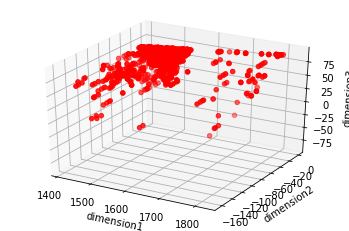

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection = "3d")

ax.scatter(x,y,z, c="r", marker="o")

ax.set_xlabel("dimension1")
ax.set_ylabel("dimension2")
ax.set_zlabel("dimension3")

plt.show()